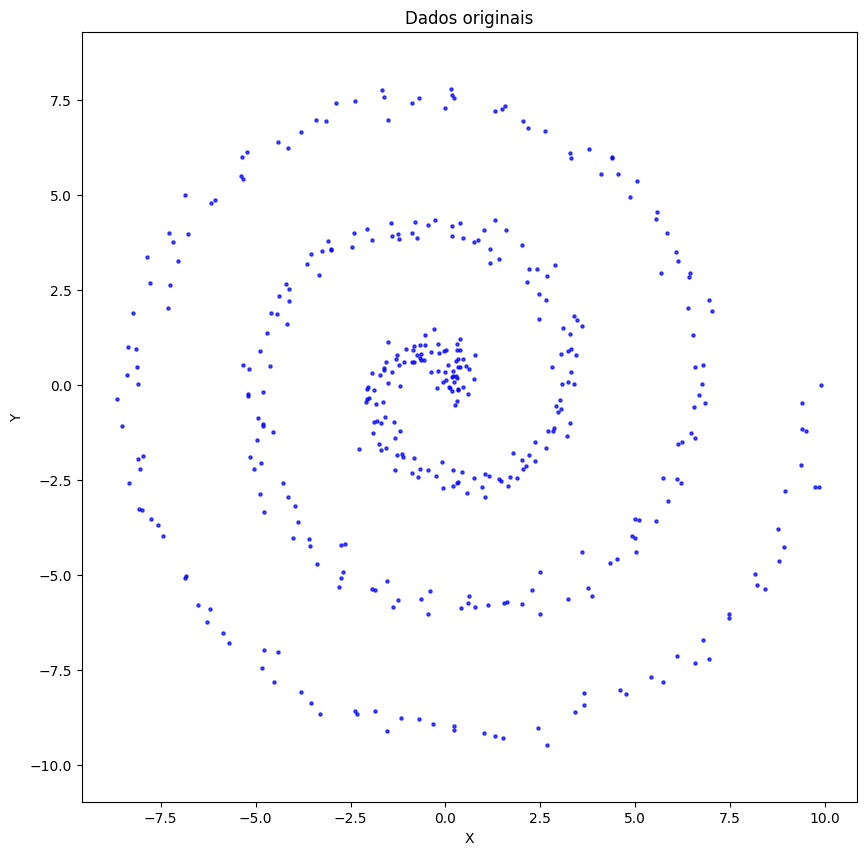

In [8]:
# Import Dataset
import pandas as pd
import matplotlib.pyplot as plt

# Load the spiral data from the CSV file
file_path = '../data/spiral_data.csv'  # Update the path if necessary
spiral_data = pd.read_csv(file_path)

# Extract x and y coordinates
x = spiral_data['x']
y = spiral_data['y']

# Plot the spiral
plt.figure(figsize=(10, 10))
plt.scatter(x, y, color='blue', alpha=0.7, s=5)
plt.axis('equal')
plt.title("Dados originais")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Número de Clusters: 31


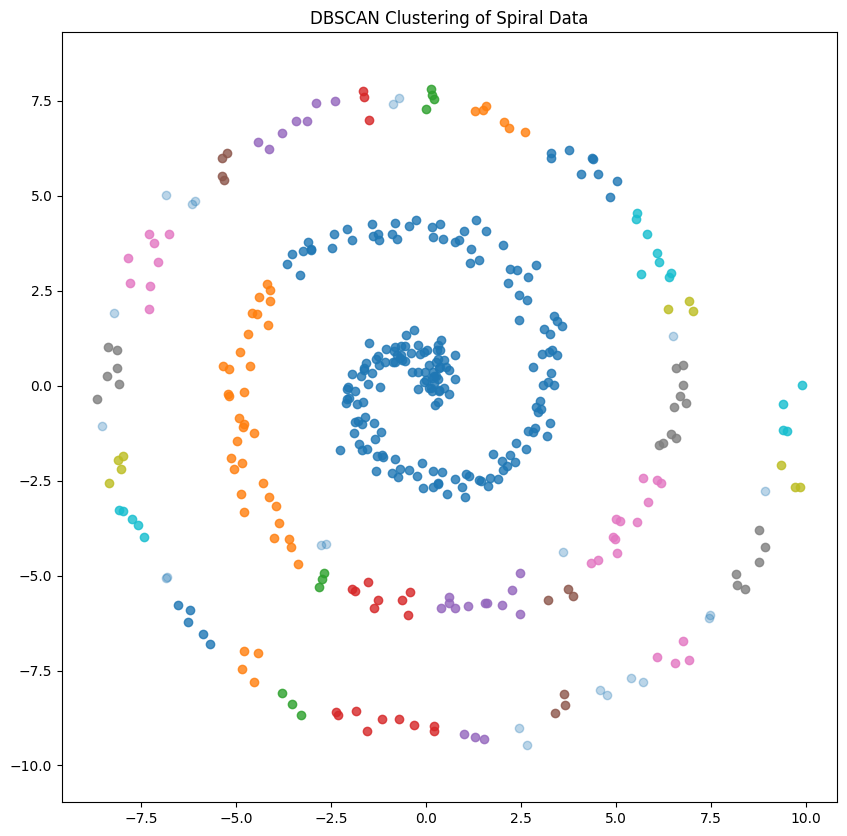

In [9]:
# DBSCAN
from sklearn.cluster import DBSCAN
import numpy as np

# Parameters for DBSCAN
eps = 0.7  # Maximum distance between two samples to be considered neighbors
min_samples = 3  # Minimum number of points in a neighborhood to form a cluster

# Stack x and y into a single array for clustering
coordinates = np.column_stack((x, y))

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(coordinates)

# Plot the clusters
plt.figure(figsize=(10, 10))
unique_labels = set(labels)
for label in unique_labels:
    if label == -1:  # Noise points
        color = 'gray'
        alpha = 0.3
    else:
        color = None  # Let matplotlib auto-assign colors to clusters
        alpha = 0.8
    cluster_points = coordinates[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {label}", alpha=alpha)
print('Número de Clusters:', len(unique_labels))
plt.axis('equal')
plt.title("DBSCAN Clustering of Spiral Data")
plt.show()


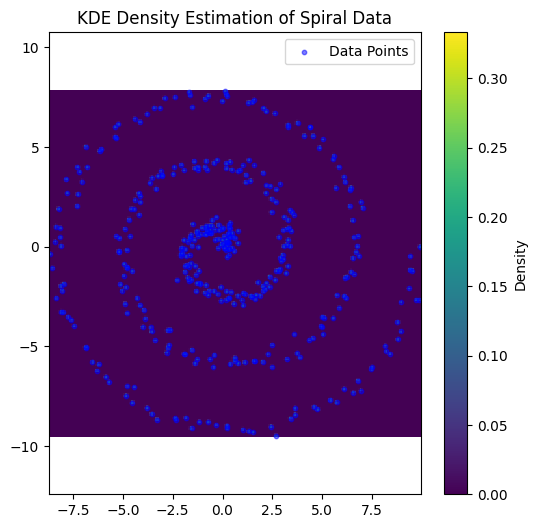

In [10]:
# Kernel Density
from sklearn.neighbors import KernelDensity
from matplotlib.colors import Normalize

# Fit KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(coordinates)

# Evaluate KDE on a grid
x_grid = np.linspace(x.min(), x.max(), 200)
y_grid = np.linspace(y.min(), y.max(), 200)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
grid_points = np.column_stack([X_grid.ravel(), Y_grid.ravel()])

# Calculate density values
log_density = kde.score_samples(grid_points)
density = np.exp(log_density).reshape(X_grid.shape)

# Plot KDE density
plt.figure(figsize=(6, 6))
plt.pcolormesh(X_grid, Y_grid, density, shading='auto', cmap='viridis', norm=Normalize(vmin=0, vmax=density.max()))
plt.colorbar(label="Density")
plt.scatter(x, y, color='blue', alpha=0.5, s=10, label="Data Points")
plt.title("KDE Density Estimation of Spiral Data")
plt.legend()
plt.axis('equal')
plt.show()

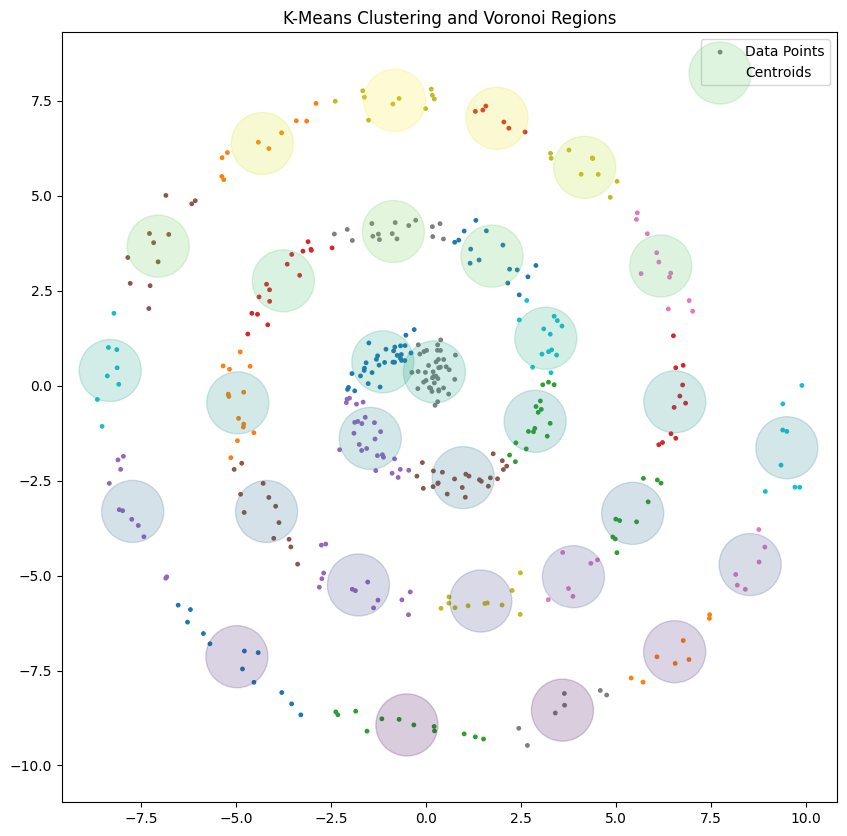

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d

# Generate synthetic data
np.random.seed(42)
coordinates = np.column_stack((x, y))

# Apply K-Means Clustering
n_clusters = 30  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(coordinates)
centroids = kmeans.cluster_centers_

# Plotting K-Means Clusters
plt.figure(figsize=(10, 10))
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=labels, cmap='tab10', s=6, label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c=centroids[:, 1], marker='o', s=2000, label='Centroids', alpha=0.2)
plt.xlim(-12, 12)
plt.ylim(-12, 12)

# Customize plot
plt.title("K-Means Clustering and Voronoi Regions")
plt.legend()
plt.axis('equal')
plt.show()

In [104]:

def create_line_segment(center, direction, length):
    """
    Create a line segment with mean in point A, direction D, and length L.

    Parameters:
        A (array-like): The mean of the line segment (e.g., [x, y]).
        D (array-like): The direction of the line segment (e.g., [dx, dy]).
        L (float): The length of the line segment.

    Returns:
        tuple: Two points representing the endpoints of the line segment.
    """
    # Convert inputs to NumPy arrays
    center = np.array(center)
    direction = np.array(direction)

    # Normalize the direction vector
    D_normalized = direction / np.linalg.norm(direction)


    # Calculate the endpoint
    startpoint = center - length / 2 * D_normalized    
    endpoint = center + length / 2 * D_normalized

    # Return the two endpoints of the line segment
    return np.array([startpoint, endpoint])

def distance_point_to_segment(point, segment):
    # Descompactar coordenadas
    px, py = point
    segment_start, segment_end = segment
    x1, y1 = segment_start
    x2, y2 = segment_end

    # Vetores
    AP = np.array([px - x1, py - y1])
    AB = np.array([x2 - x1, y2 - y1])
    
    # Comprimento ao quadrado do segmento
    AB_length_squared = AB.dot(AB)
    
    if AB_length_squared == 0:
        # A e B são o mesmo ponto
        return np.linalg.norm(AP)
    
    # Projeção escalar
    t = AP.dot(AB) / AB_length_squared

    # Restringir t ao intervalo [0, 1] (será que se colocarmos uma margem ou um ruído para permitir que as linhas crescam e diminuam, dá bom?)
    if (t < 0): t = 0
    if (t > 1): t = 1
    
    # Ponto projetado no segmento
    projection = np.array([x1, y1]) + t * AB
    
    # Distância euclidiana entre P e a projeção
    distance = np.linalg.norm(np.array([px, py]) - projection)
    
    return distance


Iteração: 2
Time to get new segment: 0.5100 seconds
Time to assign_points_to_segments: 0.0090 seconds
Time to update_segments: 0.0010 seconds
Iteração: 3
Time to get new segment: 0.5230 seconds
Time to assign_points_to_segments: 0.0140 seconds
Time to update_segments: 0.0020 seconds
Iteração: 4
Time to get new segment: 0.5410 seconds
Time to assign_points_to_segments: 0.0180 seconds
Time to update_segments: 0.0020 seconds
Iteração: 5
Time to get new segment: 0.5200 seconds
Time to assign_points_to_segments: 0.0230 seconds
Time to update_segments: 0.0030 seconds
Iteração: 6
Time to get new segment: 0.5131 seconds
Time to assign_points_to_segments: 0.0269 seconds
Time to update_segments: 0.0020 seconds
Iteração: 7
Time to get new segment: 0.5190 seconds
Time to assign_points_to_segments: 0.0310 seconds
Time to update_segments: 0.0040 seconds
Iteração: 8
Time to get new segment: 0.5340 seconds
Time to assign_points_to_segments: 0.0340 seconds
Time to update_segments: 0.0041 seconds
Iteraç

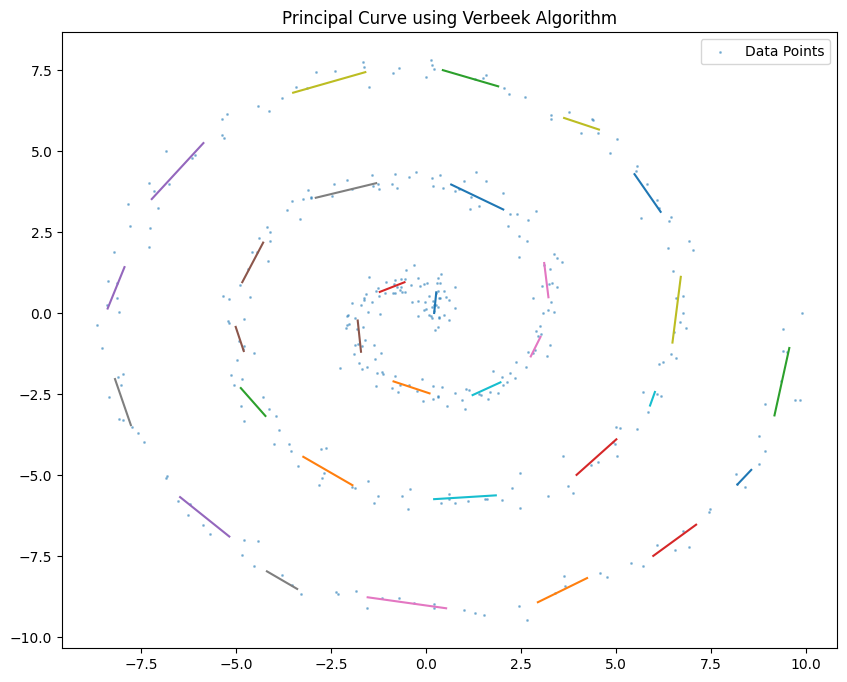

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import time

def get_new_segment(data, segments):
    if (len(segments) == 0):
        return update_single_segment(data)
    
    min_total_distance = float('inf')
    best_point = None
    min_distances = []
    for point in data:
        segments_distances = [distance_point_to_segment(point, segment) for segment in segments]
        min_distances.append([point, min(segments_distances)])
    for candidate_point in data:        
        total_distance = 0
        
        for point_dist in min_distances:            
            point, dist = point_dist
            point_to_candidate_dist = np.linalg.norm(point - candidate_point) 
            total_distance += min(dist, point_to_candidate_dist)
        if total_distance < min_total_distance:
            min_total_distance = total_distance
            best_point = candidate_point

    # Return the best point as the new segment
    return np.array([best_point, best_point])
    
    
def update_single_segment(cluster_points):        
    pca = PCA(n_components=1)
    pca.fit(cluster_points)
    direction = pca.components_[0]
    std_dev = np.sqrt(pca.explained_variance_[0])           
    length = 3 / 2 * std_dev 
    mean = cluster_points.mean(axis=0)
    return create_line_segment(mean, direction, length)              
    
# Retorna a qual segmento cada ponto está mais próximo
def assign_points_to_segments(data, segments):
    assignments = []
    for point in data:
        distances = [distance_point_to_segment(point, segment) for segment in segments]
        assignments.append(np.argmin(distances))
    return assignments


def update_segments(data, assignments, k):
    segments = []
    for i in range(k):
        cluster_points = data[np.array(assignments) == i]
        if len(cluster_points) > 0:
            segment = update_single_segment(cluster_points)
            segments.append(segment)        
    return segments

# Função principal
def k_segments_algorithm(data, k_max=5):    
    segments = [get_new_segment(data, [])]
    history = [[segments, "k = 1"]]
    for k in range(2, k_max + 2):
        print(f"Iteração: {k}")
        start_time = time.time()
        new_seg = get_new_segment(data, segments)
        segments.append(new_seg)
        print(f"Time to get new segment: {time.time() - start_time:.4f} seconds")
        
        start_time = time.time()        
        voronoi_regions = assign_points_to_segments(data, segments)
        print(f"Time to assign_points_to_segments: {time.time() - start_time:.4f} seconds")
                
        start_time = time.time()        
        segments = update_segments(data, voronoi_regions, k)
        print(f"Time to update_segments: {time.time() - start_time:.4f} seconds")
        
        history.append([segments, "k = " + str(k)])
    return segments, history
        
result_segments, segments_history = k_segments_algorithm(coordinates, 30)


def plot_segments(segments, plt):
    """
    Plots a line between each consecutive pair of points in a NumPy array.

    Parameters:
        points (numpy.ndarray): A 2D array of shape (n, 2), where each row is a point [x, y].
    """
    for i in range(len(segments)):
        # Extract consecutive pairs of points
        start, end = segments[i]

        # Plot the line between the points
        plt.plot([start[0], end[0]], [start[1], end[1]])


plt.figure(figsize=(10, 8))
plt.scatter(coordinates[:, 0], coordinates[:, 1], label='Data Points', alpha=0.4, s=5, marker='.')
plot_segments(result_segments, plt)
plt.legend()
plt.title('Principal Curve using Verbeek Algorithm')
plt.show()

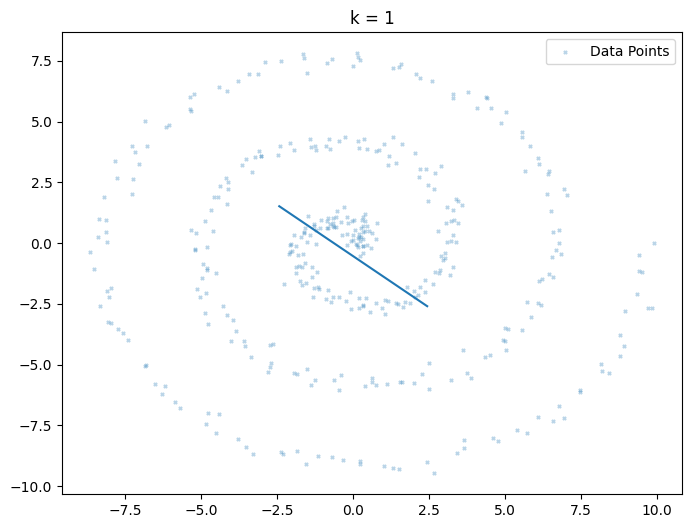

In [125]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML


# Animation
fig, ax = plt.subplots(figsize=(8, 6))

def update(frame):
    ax.clear()
    segments, title = segments_history[frame]
    ax.scatter(coordinates[:, 0], coordinates[:, 1], alpha=0.3, s=5, label='Data Points', marker='x')
    plot_segments(segments, ax)
    ax.legend()
    ax.set_title(title)

ani = FuncAnimation(fig, update, frames=len(segments_history), repeat=False)
HTML(ani.to_jshtml())


In [126]:
ani.save("k_segments_animation.gif", writer=PillowWriter(fps=2))

In [ ]:
'''
Dúvidas/ideias:
0. A parte de suavização entra na conta do algoritmo ou só é calculada no final?
1. Existe alguma implementação de curvas principais que inicializa os k segmentos por meio de pontos 
usando inicialização semelhante ao do kmeans++? Pode melhorar a convergência?
1.1 Eu estou com a ideia de inicializar todos os segmentos k de uma vez, dispersados no início, e depois calcular seu tamanho.
Esse caminho levaria ao resultado correto?
2. No trabalho de 2019, é dito que o valor do tamanho de cada segmento pode alterar muito a eficácia do algoritmo para classificação, 
contradizendo os 3/2*desvio_padrao do Verbeek, dependendo do dataset utilizado. Tive uma intuição que talvez seja interessante: 
    se usarmos informações a respeito dos clusters dos segmentos ao redor de cada segmento, como média, número de pontos, distância entre as médias, desvio padrão, variância, ou até mesmo a segunda componente principal 
    podemos obter uma medida mais precisa do tamanho de cada segmento a cada iteração, 
    e talvez até encontrar um lambda para cada segmento que melhor conecte-os.
    
    Isso porque se o nosso objetivo é traçar uma curva que aproxime os dados, e essa curva, ora é um segmento de reta, ora uma spine, 
    o tamanho de cada segmento de reta influenciará a ligação com os dois segmentos de reta adjacentes.
    
    Minha intuição é de que o tamanho de cada segmento de reta de uma "curva ideal" perfeitamente suavizada, 
    deveria ser determinado a partir de uma spine, que, a cada "nó" teria como direção a Componente Principal de primeira ordem do cluster ao redor,
    mas teria uma tangente que é proporcional ao peso daquele agrupamento de dados naquela região, em relação aos segmentos mais próximos.

    Se dois segmentos próximos tiverem um desvio padrão muito distinto, 
    isso pode gerar distorções na curva encontrada se usarmos medições diretamente proporcionais ao desvio padrão e lambda constante. 
    Como poderíamos encontrar lambda, e o tamanho de cada segmento de forma mais precisa apenas olhando para os dados?
3. Olhando para os datasets dos artigos de 2019 me veio uma ideia que pode auxiliar na classficação:
    E se ao invés de serem linhas unidimensionais, criarmos linhas com uma "grossura"? 
    Para fazer isso, uma boa heurística seria utilizar a segunda componente principal. 
    Isso aumentaria a dimensão resultante e a complexidade, mas talvez, para datasets com muitas variáveis e não muitos dados, seja interessante.

4. Será que seria possível ganhar performance fazendo de forma recursiva? Começa com um segmento, depois corta no meio e ajusta e assim por diante? 
Usa mais memória, mas funcionaria como uma busca binária, fácil de paralelizar.
'''

'\nDúvidas/ideias:\n1. Existe alguma implementação de curvas principais que inicializa os k segmentos por meio de pontos \nusando inicialização semelhante ao do kmeans++? Pode melhorar a convergência?\n1.1 Eu estou com a ideia de inicializar todos os segmentos k de uma vez, dispersados no início, e depois calcular seu tamanho.\nEsse caminho levaria ao resultado correto?\n2. No trabalho de 2019, é dito que o valor do tamanho de cada segmento pode alterar muito a eficácia do algoritmo para classificação, \ncontradizendo os 3/2*desvio_padrao do Verbeek, dependendo do dataset utilizado. Tive uma intuição que talvez seja interessante: \n    se usarmos informações a respeito dos clusters dos segmentos ao redor de cada segmento, como média, número de pontos, distância entre as médias, desvio padrão, variância, ou até mesmo a segunda componente principal \n    podemos obter uma medida mais precisa do tamanho de cada segmento a cada iteração, \n    e talvez até encontrar um lambda para cada seg